<a href="https://colab.research.google.com/github/sawao7/VAE/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **VAE(変分オートエンコーダー)をpytorchを用いて実装**
### **①オートエンコーダーとは**
変分オートエンコーダーを説明する前に、まずはオートエンコーダーについて解説する。
オートエンコーダーの特徴は、
1.   教師データが存在しないこと
2.   入力データと同じデータを返すように学習する
3.   入力データの重要な特徴量だけを残すことで次元削減が可能

この２点である。
例えば、今回使用するMNISTの画像を入力すると、同じ画像が出力される。

### **②VAE(変分オートエンコーダー)とは**
オートエンコーダーのエンコーダーとデコーダーの間に存在する潜在変数zに何かしらの確率分布が存在すると過程して学習する。
※以下数式を用いた説明
今回は、エンコーダーにガウス分布、デコーダーにベルヌーイ分布を用いる。


*   エンコーダー(ガウス分布) $$q_{\phi}({\bf z}|{\bf x}) = {\mathcal N}({\bf z}| g^{\mu}_{\phi}({\bf x}),(g^{\sigma}_{\phi}({\bf x})^2{\bf I}) $$
*   デコーダ（ベルヌーイ分布）：$$p_{\theta}({\bf x}|{\bf z}) = Ber({\bf x}| f_{\theta}({\bf z}))$$

次に、VAEの目的関数。
$$
 {\mathcal L}({\bf x};{\bf \theta},{\bf \phi}) = \mathbb{E}_{q_{\phi}({\bf z}|{\bf x})}[\log p_\theta({\bf x}|{\bf z})] -D_{KL}[q_{\phi}({\bf z}|{\bf x})||p_{\theta}({\bf z})]
 $$  

 第一項が再構成したときに生じる誤差、第二項は正則化の項
KLとは、KLダイバージェンスのことで、必ず非負の値を取るため、ここでは細かい変換は割愛するが、結局は対数周辺尤度$$log p_\theta(x)$$を最大化することは目的関数を最大化することと同じになる。

目的関数の第一項は, 次のようにサンプル近似できる.
$$
  \mathbb{E}_{q_{\phi}({\bf z}|{\bf x})}[\log p_\theta({\bf x}|{\bf z})]\simeq \frac{1}{L}\sum_{l=1}^L\log p_\theta({\bf x}|{\bf z}^{(l)}),  　ただし{\bf z}^{(l)} = \mu + \sigma \odot \epsilon^{(l)}, \epsilon^{(l)}\sim N(0,{\bf I})
$$
そして、今回はデコーダーはベルヌーイ分布なため次の式に変換できる。
$$
  \frac{1}{L}\sum_{l=1}^L\log p_\theta({\bf x}|{\bf z}^{(l)})=\frac{1}{L}\sum_{l=1}^L \sum_{i=1}^D (x_i \log \lambda^{(l)}_i + (1-x_i)\log (1-\lambda^{(l)}_i)),　ただし\lambda^{(l)}=f_{\theta}({\bf z}^{(l)})
$$

第二項の正則化項は詳しくは割愛するが、次のようになる
$$
  D_{KL}[q_{\phi}({\bf z}|{\bf x})||p_{\theta}({\bf z})] = -\frac{1}{2}\sum_{j=1}^J(1+\log(\sigma_j^2)-\mu_j^2-\sigma_j^2), 　ただしp_{\theta}({\bf z})={\cal N}(0,{\bf I})
$$




### **③VAEの実装**
では、実際にVAEモデルの実装に入る。今回は前述の通りpytorchを利用してMNISTの画像を生成する。(数字が遷移する様子も出力したい)
- まずは、ライブラリをimportする

In [ ]:
# 基本
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# pytorch関連
import torch
import torch.nn as nn # ニューラルネットワーク
import torch.nn.functional as F # ニューラルネットワークの関数(クロスエントロピーなど)
import torch.optim as optim # 最適化アルゴリズム
from torchvision import datasets, transforms # 前処理などのライブラリ

- pytorchのDataLoaderを用いて訓練、テスト用のデータローダーを作成[リンクテキスト](https://)

In [ ]:
# 前処理
transform = transforms.Compose([
    transforms.ToTensor(), 
    # Flatten tensor
    transforms.Lambda(lambda x: x.view(-1))])

# バッチサイズ
batch_size = 100

# 訓練, テスト用データローダーの作成
dataloader_train = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=False
)

dataloader_valid = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=False
)



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



## - **VAEモデルの実装**

In [ ]:
# torch.log(0)を打ち込んだときのnanを防ぐために新たな関数を定義
def torch_log(x):
    return torch.log(torch.clamp(x, min=1e-10))


class VAE(nn.Module):
    # 初期化時処理 引数にz_dim(削減された後の次元数)を入力
    def __init__(self, z_dim):
        # オーバーライド
        super(VAE, self).__init__()
        # Encoder, xを入力にガウス分布のパラメータmu, sigmaを出力
        # nn,Linearで全結合層ニューラルネットワークを定義 28*28はピクセル数
        # nn.Linear(入力の数, 出力の数)
        # エンコーダーでは最終的にz_dimの次元に削減する
        self.dense_enc1 = nn.Linear(28*28, 200)
        self.dense_enc2 = nn.Linear(200, 200)
        self.dense_encmean = nn.Linear(200, z_dim)
        self.dense_encvar = nn.Linear(200, z_dim)
        # Decoder, zを入力にベルヌーイ分布のパラメータlambdaを出力
        # デコーダーではz_dimの次元に削減されたものをもとに戻す
        self.dense_dec1 = nn.Linear(z_dim, 200)
        self.dense_dec2 = nn.Linear(200, 200)
        self.dense_dec3 = nn.Linear(200, 28*28)
    
    # エンコーダー 入力画像xを引数に受け取る
    def _encoder(self, x):
        # 活性化関数はRelu関数を採用
        x = F.relu(self.dense_enc1(x))
        x = F.relu(self.dense_enc2(x))
        # mean, std を定義した関数から作成
        mean = self.dense_encmean(x)
        std = self.dense_encvar(x)
        # stdの値が常にプラスになるように、softplus関数を使用
        # softplus関数とは、あらゆる入力値を0.0~∞の値に変換する関数
        std = F.softplus(std)
        # meanとstdが返り値
        return mean, std

    # バックプロバケーションを可能にするため, 再パラメータ化トリックを実装
    # 再パラメータ化トリックの数式は以下に表示
    def _re_parameta_trick(self, mean, std):
        return mean + std * (torch.randn(mean.shape).to(device))
    
    # デコーダー 潜在変数zを変数に受け取り、28*28に次元を復元する
    def _decoder(self, z):
        # 活性化関数にはRelu関数を使用
        x = F.relu(self.dense_dec1(z))
        x = F.relu(self.dense_dec2(x))
        # 活性関数にsigmoid関数を使用
        x = torch.sigmoid(self.dense_dec3(x))
        # 返り値xを出力
        return x

    # _encoder, _re_parameta_trick, _decoderを用いて順伝播する関数を作成
    def forward(self, x):
        mean, std = self._encoder(x)
        z = self._re_parameta_trick(mean, std)
        x = self._decoder(z)
        # 返り値に再構成画像のxと潜在変数のzを返す
        return x, z


    # 目的関数を定義(数式は上記参照)
    def loss(self, x):
        # 平均と標準偏差を求める
        mean, std = self._encoder(x)
        # KLを求める 数式は正則化項参照 ※バッチに関する平均を取る必要がある
        # 次元サイズを1に指定
        KL = -0.5 * torch.mean(torch.sum(1 + torch_log(std**2) - mean**2 - std**2, dim=1))
        z = self._re_parameta_trick(mean, std)
        y = self._decoder(z)
        # reconstruction loss(負の再構成誤差)の計算. x, yともに (batch_size , 784)
        reconstruction = torch.mean(torch.sum(x * torch_log(y) + (1 - x) *  torch_log(1  - y), dim=1))
        # KLと-reconstructionを返り値にする(この時、reconstructionを-(マイナス)にすることに注意!!!)
        return KL, -reconstruction


※再パラメータ化トリック
$${\bf z}^{(l)} = \mu + \sigma \odot \epsilon^{(l)}$$

## - **VAEモデルの学習**

では、実際に学習のコードを書いていく。

In [ ]:
# 削減された後の次元を指定(今回は10)
z_dim = 10
# イテレータを指定
epochs = 30
# モデルを指定(デバイスも指定する)
# cudaとはNvidiaが開発しているGPU向けの開発環境
device = "cuda"
model = VAE(z_dim).to(device)
# 最適化手法を指定(今回はAdamを採用する)
# Adamは、勾配を記憶する「Momentum」と、勾配の二乗を記憶する「Adagrad」を融合した手法
# optim.Adam(モデルのパラメータ, 学習率)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# イテレータを回す
for epoch in range(epochs):
    # 損失のリストを作成
    losses = []
    KL_losses = []
    reconstruction_losses = []

    # modelに学習していると通知(学習モードにする) model.eval()で推論モードにできる
    model.train()

    # 訓練用のdataloaderをループさせる。_(アンダーバー)を利用することでメモリを無駄に食わないようにしている
    for x, _ in dataloader_train:
        # tensor(テンソル)に対してcpu, gpuモードを切り替えることができる(今回はgpuモード)
        x = x.to(device)
        # 勾配を初期化
        model.zero_grad()
        # モデルの各項のlossを計算して代入
        KL_loss, reconstruction_loss = model.loss(x)
        # 合計
        loss = KL_loss + reconstruction_loss
        # 逆伝播
        loss.backward()
        # step()でパラメータを更新する
        optimizer.step()
        # 損失のリストに値を追加
        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    # テストデータの損失のリスト
    losses_test = []
    # 推論モードに変更
    model.eval()
    # テスト用のdataloaderをループさせる 
    for x, _ in dataloader_valid:
        # 訓練用の時と同じ
        x = x.to(device)
        KL_loss, reconstruction_loss = model.loss(x)
        loss = KL_loss + reconstruction_loss
        # 損失のリストに値を追加
        losses_test.append(loss.cpu().detach().numpy())

    # 一回のepochごとにそれぞれの損失を出力(もちろん損失は低いほうがいいため、epochごとに下がるはずである)
    # %dや%lfは、その値の型を指定している。%dは十進数, %fは不動小数点(%lfもその一種)
    # 損失のリストの平均を取っている(np.averageを使用)。
    # epochは0から始まっているので、直感的になるように+1している。
    print('EPOCH: %d    Train loss: %lf (KL_loss: %lf. reconstruction_loss: %lf)    Valid loss: %lf' %
          (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_test)))

RuntimeError: ignored

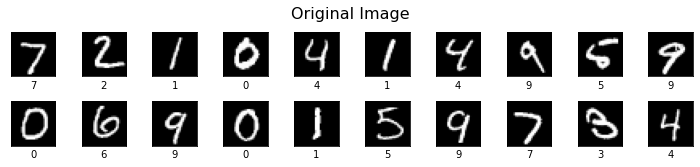

In [ ]:
# MNISTデータセットを読み込む
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
# plt(matplotlib)を用いて画像の大きさを指定
fig = plt.figure(figsize=(10, 10))
# 画像のタイトルを指定
fig.suptitle('Original Image', fontsize=16)

# 今回は20枚の画像を表示するため、forループで回す
for i in range(20):
    # xにはtensor, tには0~9つまり画像の数字が入る(講義では画像の数字は使われていないが、わかりやすいように出力してみる)
    x, t = valid_dataset[i]
    # x.view() 一般化すると => tensor.view(一つ目の引数に-1を指定すると, 残りの引数に指定したサイズに自動調整してくれる)
    # .permute() 軸の順番を入れ替える
    # .suqueeze() 要素が1のみの軸を削除(サイズが1の次元を削除)
    # numpy() tensorをnumpy配列型に変換(画像を出力するため)
    im = x.view(-1, 28, 28).permute(1, 2, 0).squeeze().numpy()
    # 画像を追加 (xticksやyticksは座標軸)
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    # 画像の下に数字を表示
    ax.set_xlabel(t)
    # 画像を表示 "gray"でグレースケールの画像を表示するように設定
    ax.imshow(im, "gray")
# 画像ごとの間隔を指定
fig.tight_layout(rect=[0,0,1,0.96])

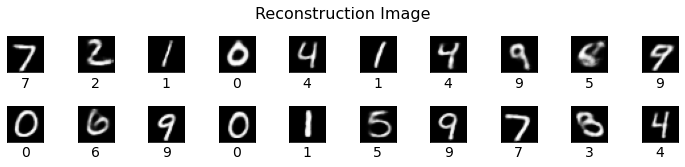

In [ ]:
# 上記のコードと全く同じ(タイトルだけ変えている)
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Reconstruction Image', fontsize=16)

# モデルを推論モードにする
model.eval()
# 20枚の画像を出力したい
for i in range(20):
    # xにはtensor, tには0~9つまり画像の数字が入る(講義では画像の数字は使われていないが、わかりやすいように出力してみる)
    x, t = valid_dataset[i]
    # unsqueeze() 要素が1のみの軸を追加(サイズが1の次元を追加)
    x = x.to(device).unsqueeze(0) # [784] -> [1, 784]
    # modelで推論した結果を代入
    y, z = model(x)
    # cpu() tensorのデバイスをcpuに切り替える
    # detach() 同一デバイス上に新しいtensorを作成(コピーみたいなものだが、厳密には違う) 変数を切り離し、定数のTensorにしている
    # ※detach() がない状態でnumpy()を呼ぶとエラーが出る
    im = y.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    # 画像の下に数字を表示
    ax.set_xlabel(t)
    ax.imshow(im, 'gray')
fig.tight_layout(rect=[0,0,1,0.96])


## - **潜在変数を、t-SNEを用いて次元削減して2次元空間に描画する**

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


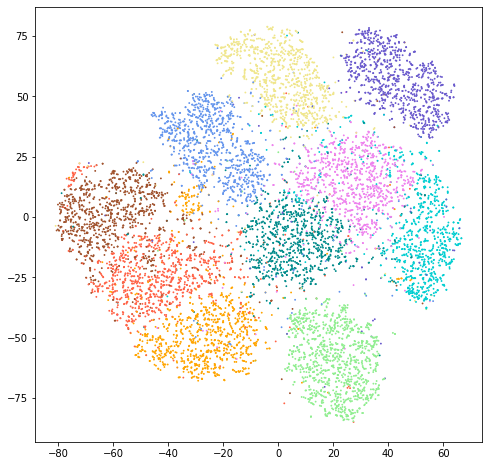

In [ ]:
# 今回はt-SNEを用いて次元削減を行う(他にもUMAP, PCA, PCA+UMAPなどたくさんの種類がある)
dim_red = "TSNE"

valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
model.eval()

# 数字のリスト(0~9)
t_list = []
# 潜在変数のリスト
z_list = []
# テストデータセットをfor文でループ
for x, t in valid_dataset:
    # 数字(0~9)をリストに追加
    t_list.append(t)
    x = x.to(device).unsqueeze(0)
    y, z = model(x)
    # 潜在変数をリストに追加
    z_list.append(z.cpu().detach().numpy()[0])

# t-SNE(次元削減するためのライブラリ)をimport
from sklearn.manifold import TSNE
# TSNE(次元数を指定) で2次元に　<= この時点ではz_listの次元は削減されてない
# fit_transform(データ) sklearn固有のメソッドで、引数のデータに基づき学習する
# .T 行と列を入れ替える
z_list = TSNE(n_components=2).fit_transform(z_list).T

# 図にプロットする時の色(colorsリストのインデックスが、数字(0~9)に対応している)
colors = ['khaki', 'lightgreen', 'cornflowerblue', 'violet', 'sienna', 'darkturquoise', 'slateblue', 'orange',
                        'darkcyan', 'tomato']

# 先程数字の画像を20枚出力した時は、複数の画像を出力したため、add_subplot()を用いた
# 今回は1枚しか表示しないため、axを用いずに描画する
# 画像(今回はグラフ)サイズを指定(8*8)
plt.figure(figsize=(8,8))
# scatter(x軸, y軸, 点のサイズ, 色) 散布図を表示するメソッド(matplotlib)
# [colors[t] for t in t_list] <= for文を1行で書けるように短縮している ここでは、数字(0~9)ごとに異なる色を指定するために用いる
plt.scatter(z_list[0], z_list[1], s=0.7, c=[colors[t] for t in t_list])


## - **最後に総仕上げとして0~9までに数字が遷移する過程をお見せしたい**

In [ ]:
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
model.eval()

# テスト用データセットから数字が0の画像を指定
# つまり、tには0が代入されている
x0, t = valid_dataset[13]
x0 = x0.to(device).unsqueeze(0)
# y0にはtensorが、z0には潜在変数が代入
y0, z0 = model(x0)
# 上記を0~9まで繰り返す(これで0~9の生成画像の潜在変数を取得できる)
x1, t = valid_dataset[14]
x1 = x1.to(device).unsqueeze(0)
y1, z1 = model(x1)
x2, t = valid_dataset[35]
x2 = x2.to(device).unsqueeze(0)
y2, z2 = model(x2)
x3, t = valid_dataset[30]
x3 = x3.to(device).unsqueeze(0)
y3, z3 = model(x3)
x4, t = valid_dataset[19]
x4 = x4.to(device).unsqueeze(0)
y4, z4 = model(x4)
x5, t = valid_dataset[23]
x5 = x5.to(device).unsqueeze(0)
y5, z5 = model(x5)
x6, t = valid_dataset[21]
x6 = x6.to(device).unsqueeze(0)
y6, z6 = model(x6)
x7, t = valid_dataset[34]
x7 = x7.to(device).unsqueeze(0)
y7, z7 = model(x7)
x8, t = valid_dataset[94]
x8 = x8.to(device).unsqueeze(0)
y8, z8 = model(x8)
x9, t = valid_dataset[12]
x9 = x9.to(device).unsqueeze(0)
y9, z9 = model(x9)

In [ ]:
fig = plt.figure(figsize=(5, 5))
# 潜在変数リスト
z = [z0, z1, z2, z3, z4, z5, z6, z7, z8, z9]
# どのくらい細かく遷移させるのか
transition_num = 20
# 0=>1=>2=>3.....=>9のように遷移させたいためfor文を用いる
for num in range(len(z)):
    # torch.cat() tensorを結合
    # 例えばnum=0の時、z0(つまり0の画像の潜在変数)からz1(つまり1の画像の潜在変数)になるまでの間の潜在変数をリスト化している
    # range(引数)  引数の数に応じて潜在変数のリストの数が決まる。多ければ多いほど細かく遷移の様子を見ることができる
    # num=8の時は、z9(つまり9の画像の潜在変数)からz0(つまり0の画像の潜在変数)までの遷移変数をリスト化している
    if num == 9:
        z_linear = torch.cat([z[num] * ((9 - i) * 0.1) + z[0] * (i * 0.1) for i in range(transition_num)])
    else:
        num_plus = num + 1
        z_linear = torch.cat([z[num] * ((9 - i) * 0.1) + z[num_plus] * (i * 0.1) for i in range(transition_num)])
    z_linear = z_linear.view((20, -1))
    # z_dimの潜在空間内で, 1を生成したベクトルから0を生成したベクトルへ少しずつ移動していきます.
    y = model._decoder(z_linear).view(-1, 28, 28).cpu().detach().numpy()
    # enumerate() イテラブルオブジェクトと共にインデックス番号のいてラブルも作成できる(インデックス番号は画像を保存する時に使用)
    for i, im in enumerate(y):
        i = i + transition_num * num
        ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
        ax.imshow(im, 'gray')
        # 画像を保存しておくディレクトリを指定(もしなければ作成)
        # パスを操作するためのライブラリをimport
        import os
        # ディレクトリ名を指定
        dir = "images"
        if os.path.exists(dir):
            pass
        else:
            os.mkdir(dir)
        # ディレクトリ名/image番号.pngで保存
        # format() を用いることで、型を意識せずに変数を文字列の中に入れ込むことができる
        # 下のコードは、ファイルの番号を順番にするため
        i = i + 10
        fig.savefig("{}/{}image{}.png".format(dir, num, i))
        # 画像を削除(削除しないとどんどん画像が溜まっていってしまう)
        fig.delaxes(ax)

<Figure size 360x360 with 0 Axes>

In [ ]:
# gif作成に必要なライブラリをimport
from PIL import Image
import glob
 
# GIFアニメーションを作成する関数を定義
def create_gif(in_dir, out_filename):
    # ファイルパスをソートしてリストする
    path_list = sorted(glob.glob(os.path.join(*[in_dir, '*']))) 
    # 画像をappendするための空配列を定義
    imgs = []                                                  
    # ファイルのフルパスからファイル名と拡張子を抽出
    for i in range(len(path_list)):
        # 画像ファイルを1つずつ開く
        img = Image.open(path_list[i])                          
        # 画像をappendで配列に格納していく
        imgs.append(img)                                        
    # appendした画像配列をGIFにする。durationで持続時間、loopでループ数を指定可能。
    imgs[0].save(out_filename,
                 save_all=True, append_images=imgs[1:], optimize=False, duration=100, loop=0)
 
# GIFアニメーションを作成する関数を実行する
create_gif(in_dir=dir, out_filename='transition.gif')